# Abstract
In this blog post we have 2 goals. Our first goal is to find a score fucntion and a threshold that will optimize the total expected profit for a bank using any feature provided by the training data. Our second goal is to assess how our model impacts different groups of people.

What we will do is fit our data on a Logisitic Regression model to get our weight vector. Then, we will make a scoring fuction and threshold to optimize the total expected profit. 

## Grabbing the Data
In the cell below, we are loading the testing data in to a pandas dataframe consisting of 26064 samples and 12 features for each sample.

In [90]:
import pandas as pd
import torch
import numpy as np
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)

In [5]:
df_train.shape


(26064, 12)

Here are the first 5 rows of data in a table format.

In [6]:
df_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10


## Exploring the Data
In this part of our blog post, we will explore the data to understand the features and their distributions. We will also visualize the data to get a better understanding of the relationships between different features.

The bar graph below shows the number of people applying for a loan for each category along the x-axis. Each category is split into 4 groups based on the person's home ownership status. As we can see from the graph, the majority of people applying for a loan are either renters or have a mortgage. 

<Axes: xlabel='loan_intent', ylabel='count'>

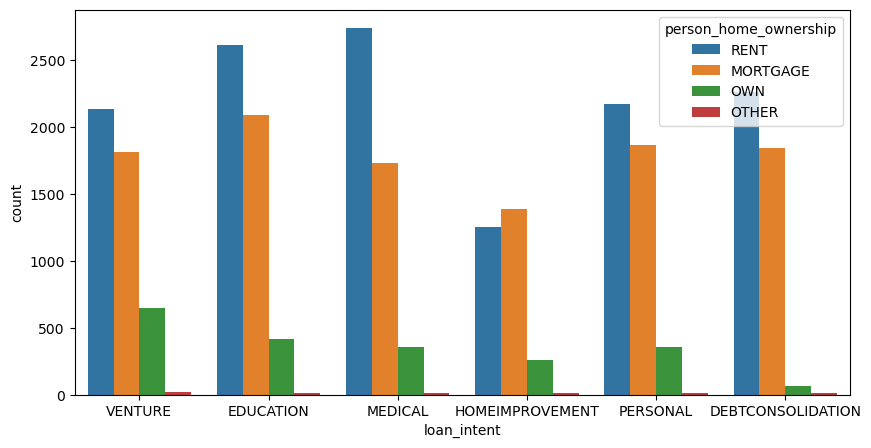

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

countplt, ax  = plt.subplots(figsize=(10, 5))
sns.countplot(df_train , x="loan_intent", hue = "person_home_ownership" )



The graph below shows the number of people applying for a loan in a certain income range. Each income range is then split into 2 groups: people who have previously defaulted on a loan and people who have not. As we can see from the graph, the majority of people applying for a loan are in the 25k to 80k range. 

<Axes: xlabel='person_income', ylabel='Count'>

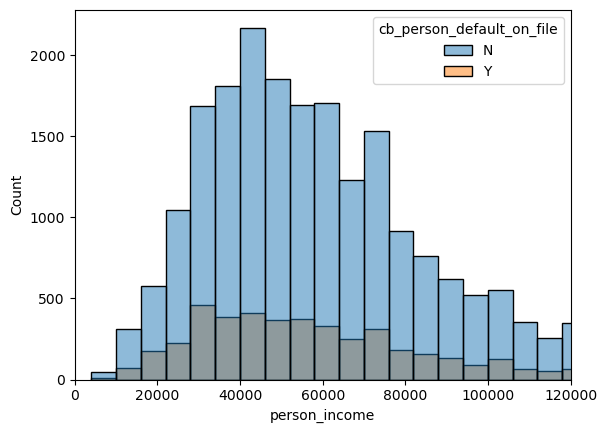

In [225]:
plt.xlim(0, 120000)
sns.histplot(df_train , x="person_income", hue = "cb_person_default_on_file", bins= 1000)

## Building the Model
In this part of our blog post, we will build a model to give a score to each person applying for a loan. Based on the scores, we will then find an optimized threshold that will maximize the total expected profit for the bank.

In [83]:
from sklearn.linear_model import LogisticRegression

Below is our definition of our linear scoring function.

In [144]:
def linear_score(w, X):
    return np.dot(w,X.T)

Here we add a new column to our dataframe called "default" to indicate whether a person has defaulted on a loan or not. This column will be used to replace the "cb_person_default_on_file" column.

In [131]:
df_train["default"] = df_train['cb_person_default_on_file'].apply(lambda x: 1 if x == "Y" else 0)
df_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,default
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4,0
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6,1
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4,0
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4,0
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10,0


The create_training_data function takes a dataframe and drops the columns that we are not using and also drops any rows with Nan values. It returns an array of features and the target variable.

In [132]:
def create_training_data(df):
    df = df.dropna()
    X = df.drop(columns=["loan_grade", "person_home_ownership","cb_person_default_on_file", "loan_intent"])
    y = df["loan_status"].values
    X = X.drop(columns=["loan_status"]).values
    return X, y
X_train, y_train = create_training_data(df_train)

We will be using the LogisticRegression class from the sklearn library to determine our weight vector. 

In [133]:
model = LogisticRegression()
model.fit(X_train, y_train)


c:\Users\robsa\anaconda3\envs\ml-451\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Here is the weight vector for our model.

In [226]:
w = model.coef_
w

array([[-1.28483263e-01, -3.60156986e-05, -2.12789100e-02,
         1.01632099e-04,  2.20494428e-01,  6.47158286e-03,
         1.44630472e-01,  3.56015601e-02]])

Now lets use our weights to calculate the score for each person applying for a loan.

In [228]:
s = linear_score(model.coef_, X_train)
s=s[0]
s

array([-1.99402521, -1.01295976, -0.51129301, ..., -0.30096269,
       -1.78451565, -1.11115349])

In the graph below, we can see the distribution of the scores for each potential loan. We can see taht most scores fall within the range of -4 and 0. 

(-10.0, 5.0)

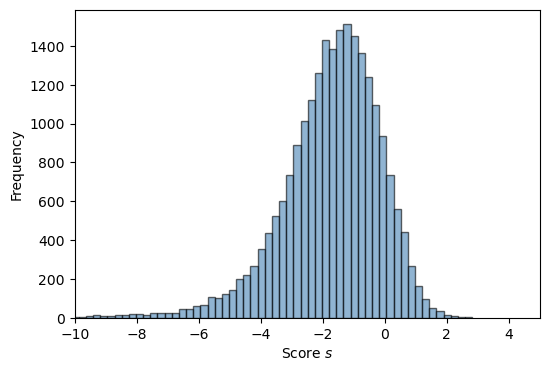

In [229]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
hist = ax.hist(s, bins = 1000, color = "steelblue", alpha = 0.6, linewidth = 1, edgecolor = "black")
labs = ax.set(xlabel = r"Score $s$", ylabel = "Frequency")
plt.xlim(-10, 5)

Here we set the threshold to -1.0 and determin whether a person is likely to default on a loan or not. In the cell below that, we see that about 34% of people are predicted to default with this threshold.

In [169]:
t = -1.0
preds = s >= t
preds

array([False, False,  True, ...,  True, False, False])

In [171]:
preds.mean()

0.3425590430872659

In the cells below, we calculate the average loan amount and the average interest rate for each loan and we calculate the average expected profit for a loan. 

In [180]:
avg_loan =df_train["loan_amnt"].values.mean()
avg_loan

9569.46842387968

In [179]:
int = df_train["loan_int_rate"].dropna()
avg_int = int.values.mean()
avg_int

11.009372400916574

In [230]:
def tn_form(loan, int_rate):
    return loan*(1 + 0.25*int_rate/100)**10 - loan
avg_tn_profit = tn_form(avg_loan, avg_int)
avg_tn_profit


2985.1973093790166

In [231]:
def fn_form(loan, int_rate):
    return loan*(1 + 0.25*int_rate/100)**3 - 1.7*loan
avg_fn_profit = fn_form(avg_loan, avg_int)
avg_fn_profit


-5886.526816942651

On average, the bank will make a profit of about $3,000 for each true negative prediction, and losses about $6,000 for each false positive prediction. So it will take about 2 true negatives to make up for 1 false positive, but since we want to make a profit, we will say that we need 3 true negatives to make up for 1 false positive.

In [232]:
avg_tn_profit/avg_fn_profit

-0.5071237084637068

The graph below shows the accuracy of our model based on what the threshold is set to. As we can see the model is at its most accurate when the threshold is set to 0.08. 

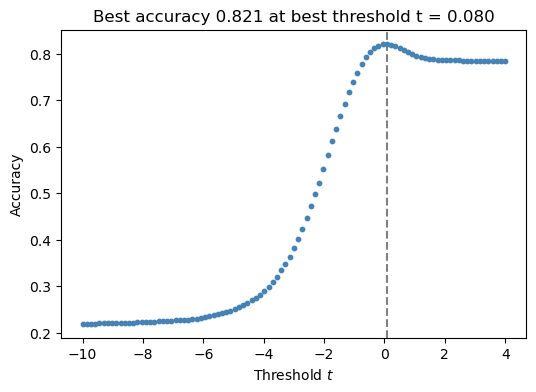

In [173]:
best_accuracy = 0
best_threshold = 0

fig, ax = plt.subplots(1, 1, figsize = (6, 4))
for t in np.linspace(-10, 4, 101): 
    y_pred = s >= t
    acc = (y_pred == y_train).mean()
    ax.scatter(t, acc, color = "steelblue", s = 10)
    if acc > best_accuracy: 
        best_accuracy = acc
        best_threshold = t
ax.axvline(best_threshold, linestyle = "--", color = "grey", zorder = -10)
labs = ax.set(xlabel = r"Threshold $t$", ylabel = "Accuracy", title = f"Best accuracy {best_accuracy:.3f} at best threshold t = {best_threshold:.3f}")

In this graph we introduce the bias for reducing the number of false positives. 

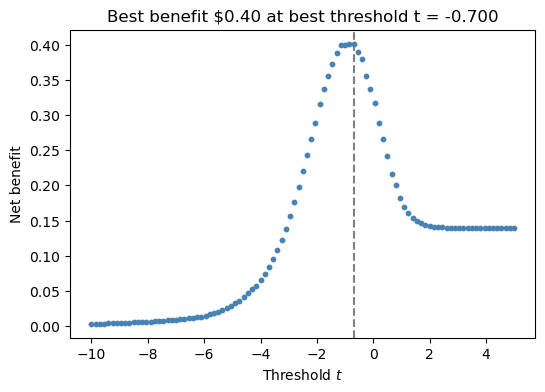

In [235]:
best_benefit = 0
best_threshold = 0

c = 1
C = 3

fig, ax = plt.subplots(1, 1, figsize = (6, 4))
for t in np.linspace(-10, 5, 101): 
    y_pred = s >= t
    tn = ((y_pred == 0) & (y_train == 0)).mean()
    fn = ((y_pred == 0) & (y_train == 1)).mean()
    benefit = c*tn - C*fn
    ax.scatter(t, benefit, color = "steelblue", s = 10)
    if benefit > best_benefit: 
        best_benefit = benefit
        best_threshold = t

ax.axvline(best_threshold, linestyle = "--", color = "grey", zorder = -10)
labs = ax.set(xlabel = r"Threshold $t$", ylabel = "Net benefit", title = f"Best benefit ${best_benefit:.2f} at best threshold t = {best_threshold:.3f}")

## Evaluating the Model
Now we will evaluate our model on test data. We will use the same scoring function and threshold that we used to train our model.

In [200]:
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)

Again, we are making a new column for whether a person has defaulted on a loan or not in the past.

In [210]:
df_test["default"] = df_test['cb_person_default_on_file'].apply(lambda x: 1 if x == "Y" else 0)

In [247]:
X_test, y_test = create_training_data(df_test)

t = -0.70

s_test = linear_score(w, X_test)

preds_test = s_test >= t
preds_test.mean()


0.2727272727272727

The results on the testing data are very similar to the results on the training data.

In [246]:

FN   = ((preds_test == 0) & (y_test == 1)).mean() 
TN   = ((preds_test == 0) & (y_test == 0)).mean() 

gain = gain = c*TN  - C*FN
gain

0.3936485779096144

In this section we will evaluate our model and see if a person's age plays a role in whether they are negatively impacted by our model. In the cells below, we make a dataframe containing people who are age 30 and under and check to see if they are disproportionately flagged as likely to default on a loan.

In [257]:
df_age = df_test[df_test["person_age"] < 30]
df_age.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,default
0,21,42000,RENT,5.0,VENTURE,D,1000,15.58,1,0.02,N,4,0
3,28,66300,MORTGAGE,11.0,MEDICAL,D,12000,14.11,1,0.15,N,6,0
4,22,70550,RENT,0.0,MEDICAL,E,7000,15.88,1,0.08,N,3,0
7,23,78500,MORTGAGE,7.0,EDUCATION,A,7200,7.49,0,0.09,N,3,0
9,23,80000,OWN,7.0,PERSONAL,B,9000,9.62,0,0.11,N,2,0


About 32% of people under 30 are predicted to default, where as only 14% of people over 30 are predicted to default. This is a significant difference and shows that our model is biased against younger people.

In [251]:
X_age, y_age = create_training_data(df_age)

s_age = linear_score(w, X_age)
preds_age = s_age >= t
preds_age.mean()

0.31852209611205023

In [259]:
df_age_older = df_test[df_test["person_age"] > 30]
X_age_older, y_age_older = create_training_data(df_age_older)

s_age_older = linear_score(w, X_age_older)
preds_age_older = s_age_older >= t
preds_age_older.mean()


0.14033798677443057

Now we will look if it is more diffcult to access credit if you intend to pay a medical expense. In the cells below, we make a dataframe containing people who are applying for a loan to pay a medical expense and check to see if they are disproportionately flagged as likely to default on a loan.

According to the result below, there is no significant difference between the percentage of people who are rejected for a loan to pay a medical expense and the percentage of people who are rejected for a loan to pay any other expense. 

In [268]:
df_med = df_test[df_test["loan_intent"] == "MEDICAL"]
X_med, y_med = create_training_data(df_med)
s_med = linear_score(w, X_med)
preds_med = s_med >= t
preds_med.mean()

0.2898415657036347

In [265]:
df_med2 = df_test[df_test["loan_intent"] != "MEDICAL"]
X_med2, y_med2 = create_training_data(df_med2)
s_med2 = linear_score(w, X_med2)
preds_med2 = s_med2 >= t
preds_med2.mean()

0.26878488621726065

We can see that people who are applying for a loan to pay a medical expense are more likely to default on a loan than people who are applying for a loan to pay any other expense.

In [269]:
y_med.mean()

0.2842497670083877

In [270]:
y_med2.mean()

0.20867325032202663

# Discussion
In this blog post, we learn about how to use score based classification to determine whether a person is likely to default on a loan. To do this, we had to find a weight vector, a scoring function, and a threshold that would maximize the total expected profit for the bank. We also learn that in defining a scoring function and threshold, we introduce bias into our model. Notably, we see that our model is biased against younger people. We found that people under 30 are more than twice as likely to be flagged as likely to default on a loan than people over 30. We also found that people applying to pay a medical expense are slighlty more likely to be flagged as compared to any other loan intent, but not significantly so.

When it comes to medical expenses, we see that people applying for a loan are more likely to default on a loan than people applying for a loan to pay any other expense. This is not surprising as medical expenses are often unexpected and can be difficult to pay off. I don't believe that it is fair to penalize people for having medical expenses because they are often unavoidable and critical for a person's wellbeing, where as other expenses are not critical needs. 